<a href="https://colab.research.google.com/github/carson-edmonds/AAI-511_Final_Project/blob/main/Feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pretty_midi --quiet
import pretty_midi

!pip install mido --quiet
import mido

import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
import mido
import string
from tqdm import tqdm

np.random.seed(42)  # makes the randomness deterministic

%matplotlib inline
# todo: try %matplotlib widget
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid'] = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import string
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [ ]:
# The wrapper function to load a MIDI file and extract features
def extract_features(file_path):
    mid = mido.MidiFile(file_path, clip=True)

    return mid2arry(mid)

In [ ]:
# Specify your directory containing MIDI folders
main_dir = '/content/drive/MyDrive/AAI 511/Final Project/Composer_Dataset/NN_midi_files_extended/train/'

# Prepare lists to store filenames and lengths
filenamelist = []
lengths = []

# Walk through all subdirectories
for dirpath, dirnames, filenames in os.walk(main_dir):
    for filename in tqdm(filenames):
      if filename.endswith('.mid'):
            full_file_path = os.path.join(dirpath, filename)  # get full file path
            mid = mido.MidiFile(full_file_path, clip=True)
            # Compute the total number of messages in all tracks
            total_msgs = sum(len(track) for track in mid.tracks)
            filenamelist.append(filename)
            lengths.append(total_msgs)

# Create a DataFrame
df = pd.DataFrame({
    'filename': filenamelist,
    'length': lengths
})

In [ ]:
# Load MIDI file into PrettyMIDI object
midi_data = pretty_midi.PrettyMIDI('/content/drive/MyDrive/AAI 511/Final Project/Composer_Dataset/NN_midi_files_extended/train/bartok/bartok396.mid')
# Print an empirical estimate of its global tempo
print ("Tempo estimate:", midi_data.estimate_tempo())
# Compute the relative amount of each semitone across the entire song,
# a proxy for key
total_velocity = sum(sum(midi_data.get_chroma()))
print ([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])
# Shift all notes up by 5 semitones
for instrument in midi_data.instruments:
    # Don't want to shift drum notes
    if not instrument.is_drum:
        for note in instrument.notes:
            note.pitch += 5
# Synthesize the resulting MIDI data using sine waves
audio_data = midi_data.synthesize()

Tempo estimate: 112.63549169686354
[0.048565004803676544, 0.0, 0.17395031688858223, 0.0, 0.19756701761568166, 0.005230670016584515, 0.11834872380675684, 0.01407977954811325, 0.0, 0.3988063991794682, 0.0, 0.04345208814113675]


In [ ]:
pm = pretty_midi.PrettyMIDI('/content/drive/MyDrive/AAI 511/Final Project/Composer_Dataset/NN_midi_files_extended/train/bartok/bartok396.mid')

In [ ]:
import librosa.display


In [ ]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

<ipython-input-21-23356387cf61>:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


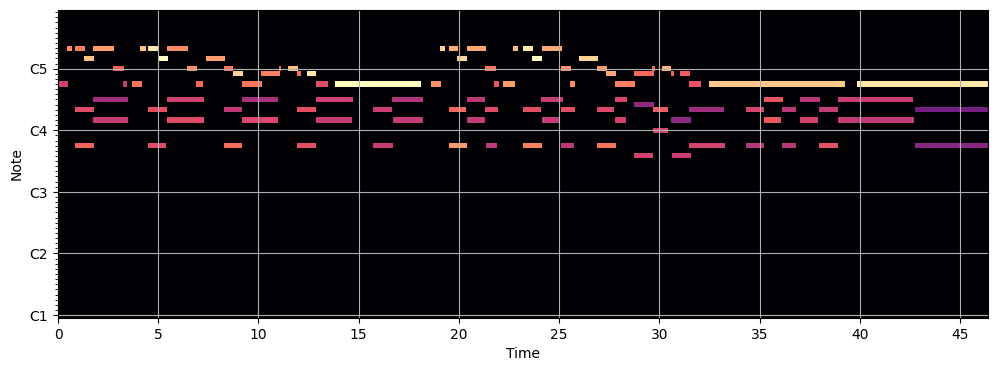

In [ ]:
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

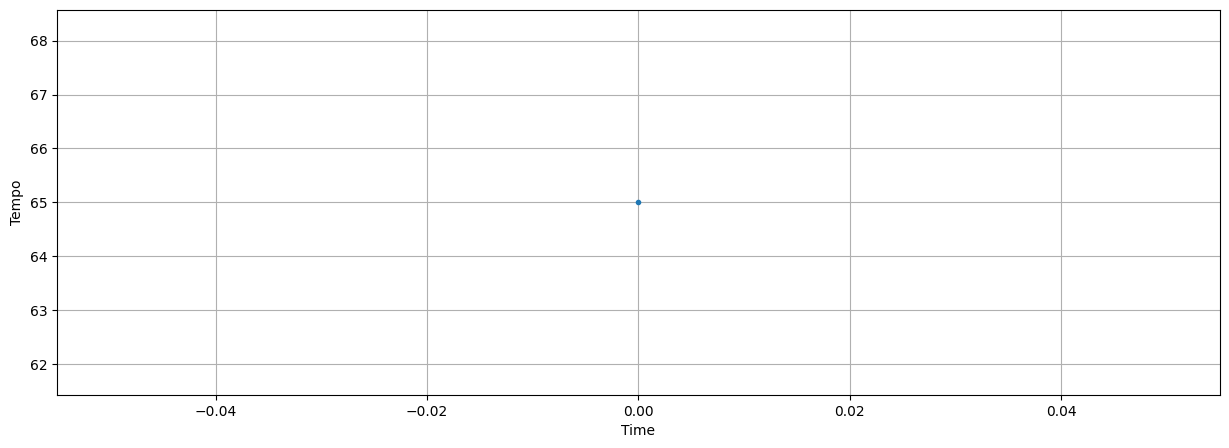

In [ ]:
# Plot the tempo changes over time
# Many MIDI files won't have more than one tempo change event,
times, tempo_changes = pm.get_tempo_changes()
plt.plot(times, tempo_changes, '.')
plt.xlabel('Time')
plt.ylabel('Tempo');

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100706 sha256=5fc4949c6082203159428287684e8173f5bfae57d873f2e81a363a8c70ae0ac0
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


<ipython-input-21-23356387cf61>:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


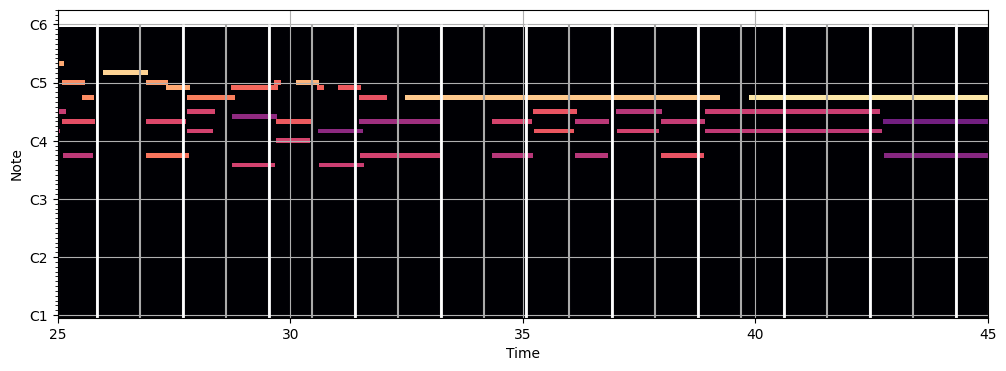

In [ ]:
!pip install mir_eval --quiet
import mir_eval.display
# Get and downbeat times
beats = pm.get_beats()
downbeats = pm.get_downbeats()
# Plot piano roll
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)
ymin, ymax = plt.ylim()
# Plot beats as grey lines, downbeats as white lines
mir_eval.display.events(beats, base=ymin, height=ymax, color='#AAAAAA')
mir_eval.display.events(downbeats, base=ymin, height=ymax, color='#FFFFFF', lw=2)
# Only display 20 seconds for clarity
plt.xlim(25, 45);

Text(0, 0.5, 'Proportion')

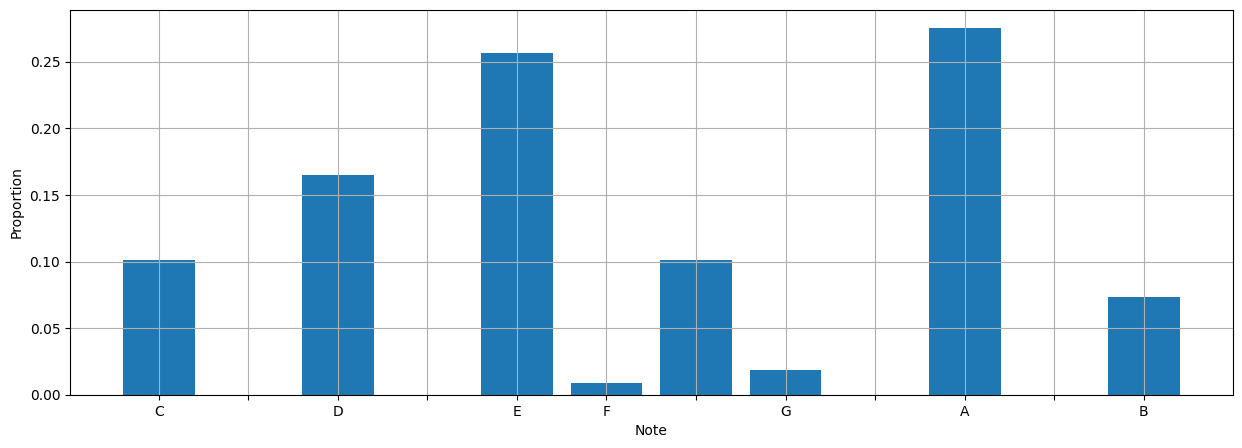

In [ ]:
# Plot a pitch class distribution - sort of a proxy for key
plt.bar(np.arange(12), pm.get_pitch_class_histogram());
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')

In [ ]:
# Let's count the number of transitions from C to D in this song
n_c_to_d = 0
for instrument in pm.instruments:
    # Drum instrument notes don't have pitches!
    if instrument.is_drum:
        continue
    for first_note, second_note in zip(instrument.notes[:-1], instrument.notes[1:]):
        n_c_to_d += (first_note.pitch % 12 == 0) and (second_note.pitch % 12 == 2)
print('{} C-to-D transitions.'.format(n_c_to_d))

0 C-to-D transitions.


In [1]:
import music21
from music21 import *

In [5]:
def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]

    return midi.translate.midiFileToStream(mf)

base_midi = open_midi('/content/drive/MyDrive/AAI 511/Final Project/Composer_Dataset/NN_midi_files_extended/train/bartok/bartok396.mid', True)
base_midi

<music21.stream.Score 0x783ab19bdd80>

In [6]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
Grand Piano*recorded


<ipython-input-8-755e9b9abacb>:6: StreamIteratorInefficientWarning: flat is not defined on StreamIterators. Call .stream() first for efficiency
  for nt in midi_part.flat.notes:


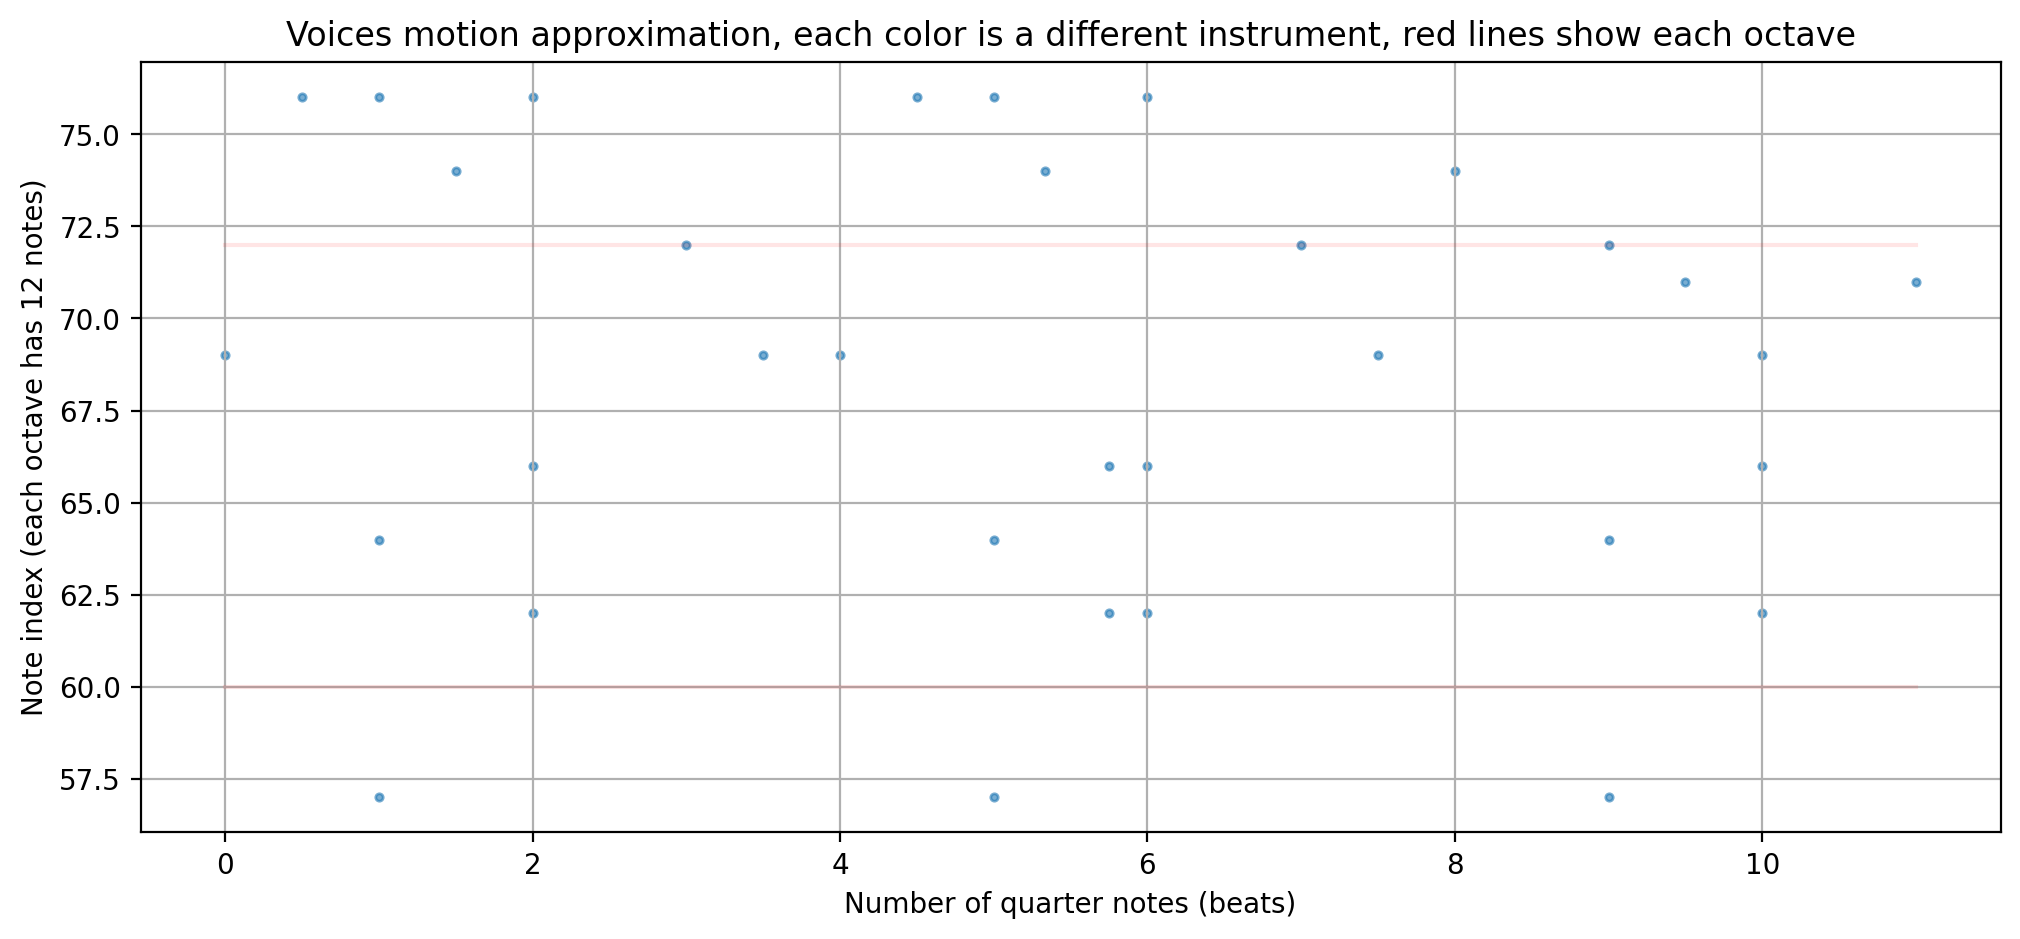

In [8]:
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)

    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0

# Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue

        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)

        aux = min(y)
        if (aux < minPitch): minPitch = aux

        aux = max(y)
        if (aux > maxPitch): maxPitch = aux

        aux = max(x)
        if (aux > xMax): xMax = aux

    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))


<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x783ab19bdd80>>

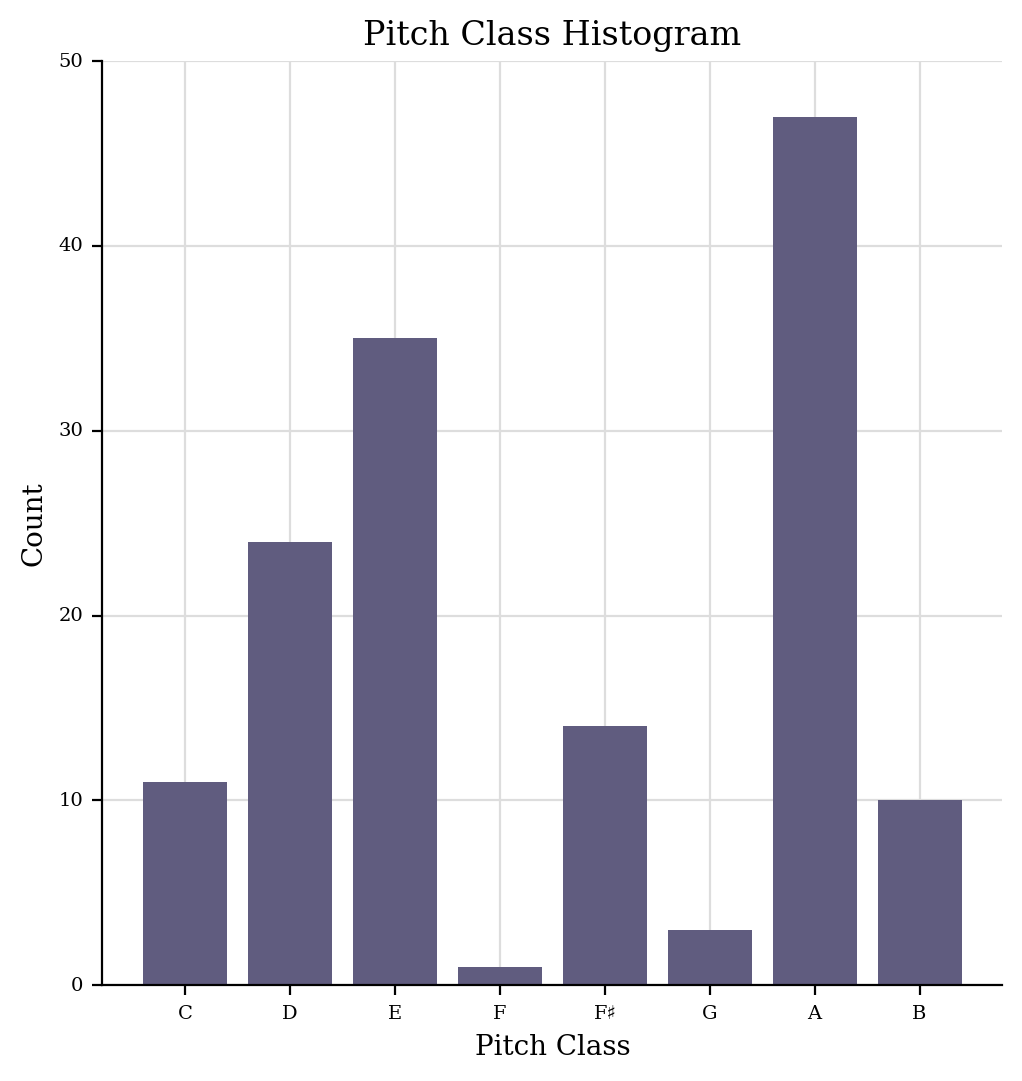

In [9]:
base_midi.plot('histogram', 'pitchClass', 'count')


<ipython-input-8-755e9b9abacb>:6: StreamIteratorInefficientWarning: flat is not defined on StreamIterators. Call .stream() first for efficiency
  for nt in midi_part.flat.notes:


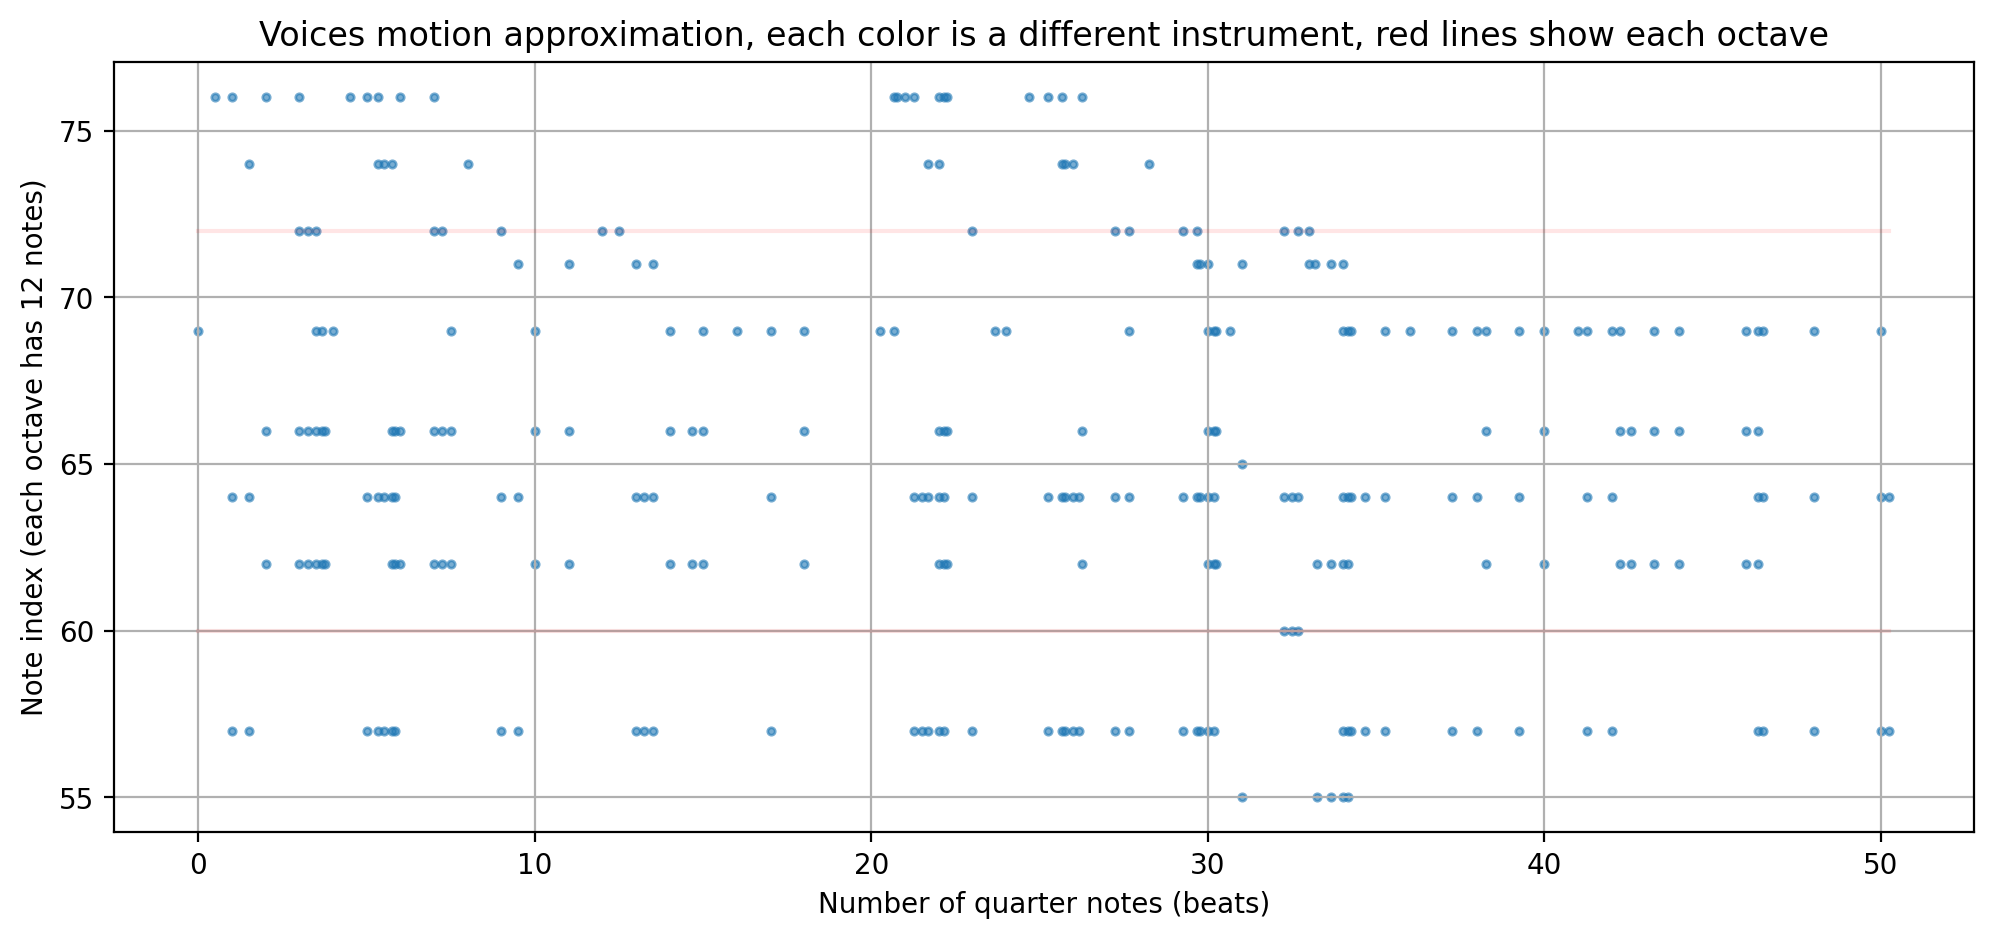

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Grand Piano*recorded: Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark adagietto Quarter=65.0>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.meter.TimeSignature 2/4>
    {0.0} <music21.chord.Chord A4>
    {0.5} <music21.chord.Chord E5>
    {0.75} <music21.note.Rest 16th>
    {1.0} <music21.chord.Chord A3 E4 E5>
    {1.5} <music21.chord.Chord A3 E4 D5>


In [10]:
temp_midi_chords = base_midi.chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")